# Boosting für Machine Learning

Wir beschäftigen uns mit den grundlegenden Varianten des sogenannten _Boostings_.
Dabei legen wir unser Augenmerk auf die Klassifikation.
Insbesondere klassifizieren wir Reden von deutschen Politikern, d.h. aus einem gegebenen Redetext ermitteln wir wer diese Rede hielt.
(Diese Problemstellung war bereits Thema im den Übungen des [codecentric.AI](https://www.codecentric.de/kuenstliche-intelligenz/) Bootcamp zum Thema [Natural Language Processing](https://www.youtube.com/watch?v=GmLsb-o7hvM).)

_Angenommen für unser Problem steht ein schlechter Klassifikator L zur Verfügung._
_Wie können wir aus K einen guten Klassifikator L erzeugen?_

Dabei wird L keine abgewandelte Form von K sein, sondern L besteht aus mehreren geschickt kombinierten Instanzen von K.

Hier beschränken wir uns auf den Fall, dass K ein einfacher [Entscheidungsbaum-Klassifikator](https://en.wikipedia.org/wiki/Decision_tree_learning) ist.
(Der gleiche Ansatz kann auch auf andere zugrunde liegende Klassifikatoren angewendet werden.)
Wir werden also sogenannte _Ensembles_ von Entscheidungsbäumen erstellen.
Die Klassifikation eines Ensembles ergibt sich aus den individuellen Klassifikationen der Entscheidungsbäume des Ensembles.

## Reden laden

Werfen wir zuerst einen Blick auf die Daten.
Wir verwenden den von Barbaresi und Adrien bereitgestellten Datensatz [1], der unter der URL [2] verfügbar ist.

[1] Barbaresi, Adrien (2018). "A corpus of German political speeches from the 21st century", Proceedings of the Eleventh International Conference on Language Resources and Evaluation (LREC 2018), European Language Resources Association (ELRA), pp. 792–797.

[2] http://purl.org/corpus/german-speeches

Hier ein Einblick in wenige zufällig ausgewählte Reden.

In [1]:
%run define_load_data_functions.ipynb

df = load_data()

display(df.sample(n=len(df)).head())

,person,speech
1030,Angela Merkel,liebe Kolleginnen und Kollegen aus dem Deutsch...
2128,Angela Merkel,"Ja, vor 20 Jahren war all das für manche noch ..."
1464,Bernd Neumann,"""Was Kultur kann"" – ich finde es durchaus schl..."
2482,Angela Merkel,"Wir wollen natürlich alles tun, um humanitären..."
33,Gerhard Schröder,Anrede\nIch begrüße Sie ganz herzlich zur Eröf...


Im Datensatz ist Angela Merkel mit der weitaus stärksten Anzahl von Reden vertreten.

In [2]:
speech_counts = df.person.value_counts()

display(speech_counts)

Angela Merkel              1125
Gerhard Schröder            418
Bernd Neumann               323
Monika Grütters             245
Christina Weiss             203
k.A.                         88
Michael Naumann              61
Julian Nida-Rümelin          47
Thomas de Maizière           43
Hans Martin Bury             42
Joschka Fischer              31
Rolf Schwanitz               24
Frank-Walter Steinmeier       7
Andere                        4
Jullian Nida-Rümelin          1
Name: person, dtype: int64

Wir beschränken uns auf die binäre Klassifikation, d.h. wir unterscheiden nur zwischen zwei Klassen von Personen.
Um auf ausgewogenen Daten zu arbeiten wählen wir die Klassen _Angela Merkel_ und _Nicht Angela Merkel (Andere)_.
Dazu vernachlässigen wir zuerst alle schwach vertretenen Personen.

In [3]:
NUM_SPEECHES_DROP_THRESHOLD = 100
belowThreshold = lambda name: speech_counts[name] < NUM_SPEECHES_DROP_THRESHOLD

dropped = filter(belowThreshold, speech_counts.index.tolist())
df.drop(df[df.person.isin(dropped)].index, inplace=True)

display(df.person.value_counts())

Angela Merkel       1125
Gerhard Schröder     418
Bernd Neumann        323
Monika Grütters      245
Christina Weiss      203
Name: person, dtype: int64

Dann fassen wir alle verbleibenden Personen zur Klasse _Andere_ zusammen.

In [13]:
df.loc[df['person'] != "Angela Merkel", ['person']] = 'Andere'

display(df.person.value_counts())

Andere           1189
Angela Merkel    1125
Name: person, dtype: int64

In [5]:
%run init_spacy.ipynb
%run define_preprocessing.ipynb

df = load_cached_or_preprocess(df.speech)

display(df.head())

,person,speech,tokens,lemmata
0,Andere,"es ist angekündigt worden, man sollte im Beruf...","[es, ist, angekündigt, worden, ,, man, sollte,...","[ich, sein, ankündigen, werden, ,, man, sollen..."
2,Andere,Frage (Peter Hahne): Bevor wir uns über den Au...,"[Frage, (, Peter, Hahne, ), :, Bevor, wir, uns...","[Frage, (, Peter, Hahn, ), :, bevor, ich, sich..."
3,Andere,"Einen Satz von Ihnen, Herr Dr. Bernotat, habe ...","[Einen, Satz, von, Ihnen, ,, Herr, Dr., Bernot...","[einer, Satz, von, ich, ,, Herr, Dr., Bernotat..."
4,Andere,diese Jahresversammlung der Hochschulrektorenk...,"[diese, Jahresversammlung, der, Hochschulrekto...","[dies, Jahresversammlung, der, Hochschulrektor..."
5,Andere,"ich habe nie einen Hehl daraus gemacht, dass i...","[ich, habe, nie, einen, Hehl, daraus, gemacht,...","[ich, habe, nie, ein, Hehl, daraus, machen, ,,..."


In [6]:
%run define_feature_computation.ipynb

(lemmata, lemma_index) = compute_index(df["lemmata"])
df["lemma_bow"] = bag_of_words(df["lemmata"], lemma_index)
df["lemma_counts"] = count(df["lemmata"], lemma_index)

display(lemmata[:20])
display(lemmata[50208])
display(df.iloc[0])

['Standort-',
 'Bewertungssituation',
 'Unconscious',
 'Kleingedrucktes',
 'Leseleidenschaft',
 'zivilisierten',
 'Fé',
 'Innovationsbedarf',
 'Außerdem',
 'Zulassungsmechanismen',
 'EP-Kulturausschusses',
 'Bankenabgabe',
 'Kadenz',
 'Kontaktbörsen',
 'Reparaturkolonne',
 'Vorwärtsbewegung',
 'Integrationsaspekte',
 'risikoreich',
 'entzogen',
 'Veranstaltungsortes']

'Handelszone'

person                                                     Andere
speech          es ist angekündigt worden, man sollte im Beruf...
tokens          [es, ist, angekündigt, worden, ,, man, sollte,...
lemmata         [ich, sein, ankündigen, werden, ,, man, sollen...
lemma_bow       {18398: 1, 67702: 1, 97649: 1, 33039: 1, 69987...
lemma_counts    {18398: 121, 67702: 50, 97649: 1, 33039: 25, 6...
Name: 0, dtype: object

In [7]:
%run define_conversion_functions.ipynb

data = dict_to_sparse(df["lemma_counts"], len(lemma_index))
categories = df["person"].astype("category")
labels = categories.cat.codes

In [8]:
%run define_plot_functions.ipynb
%run define_train_functions.ipynb

0.7640287769784173

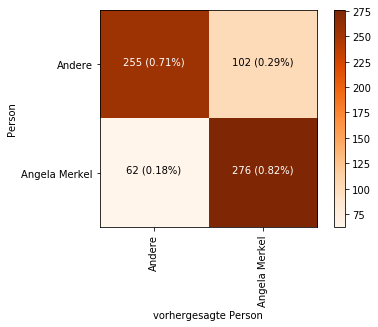

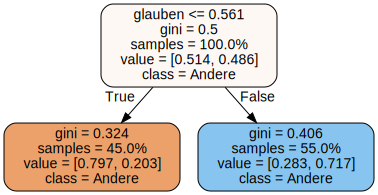

In [9]:
from sklearn.tree import DecisionTreeClassifier

TRAIN_TEST_RATIO = 0.3 # proportion of test data

def make_decision_tree_classifier():
    return DecisionTreeClassifier(splitter="random",
                                  max_depth=1,
                                  criterion="gini")

classifier = make_decision_tree_classifier()

(accuracy, confusion) = train_and_test_with(classifier,
                                            data,
                                            labels,
                                            test_size=TRAIN_TEST_RATIO)

display(accuracy)
plot_confusion_matrix(confusion, classes = categories.unique())
display_decision_tree(classifier)

0.8992805755395683

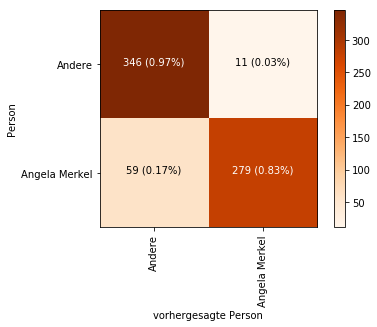

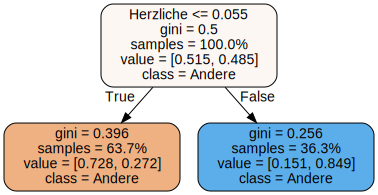

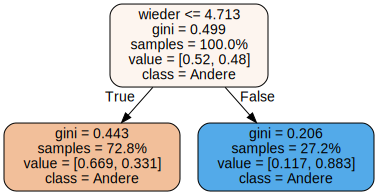

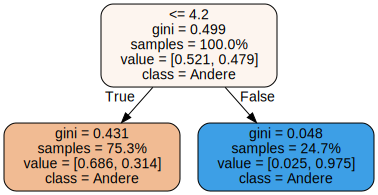

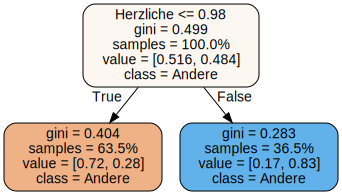

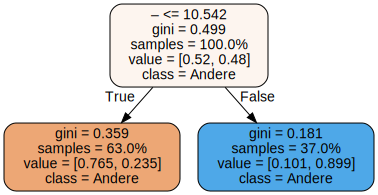

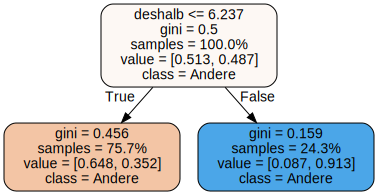

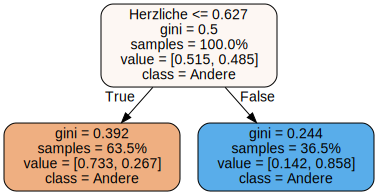

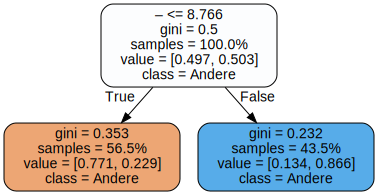

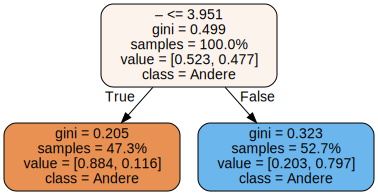

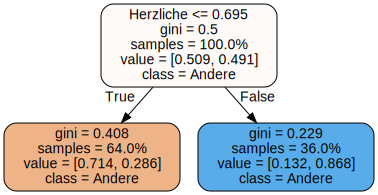

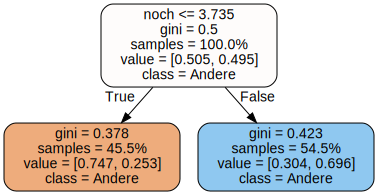

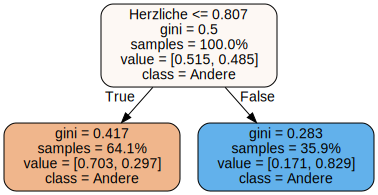

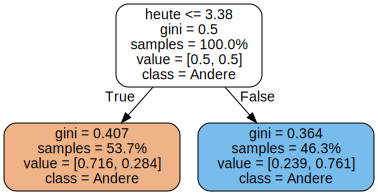

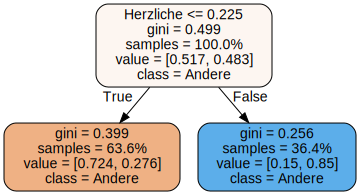

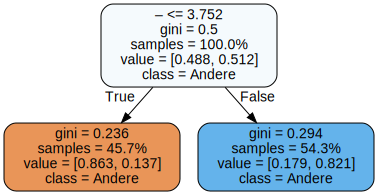

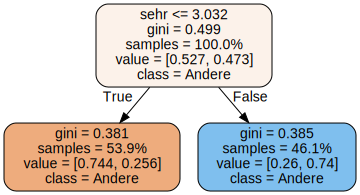

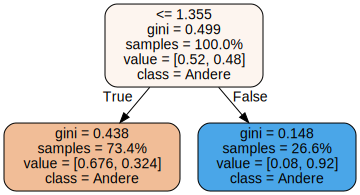

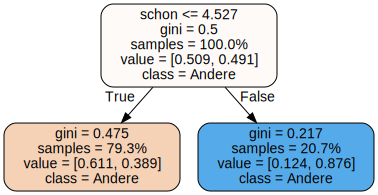

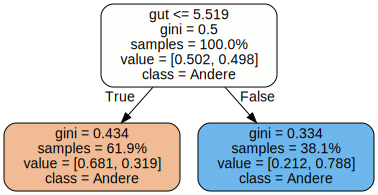

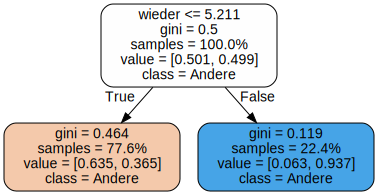

In [10]:
from sklearn.ensemble import BaggingClassifier

BOOST_FACTOR = 20
ALL_CORES = -1

base = make_decision_tree_classifier()
classifier = BaggingClassifier(base_estimator=base,
                               n_estimators=BOOST_FACTOR,
                               n_jobs=ALL_CORES)

(accuracy, confusion) = train_and_test_with(classifier,
                                            data,
                                            labels,
                                            test_size=TRAIN_TEST_RATIO)

display(accuracy)
plot_confusion_matrix(confusion, classes=categories.unique())
for tree in classifier:
    display_decision_tree(tree)

0.9640287769784173

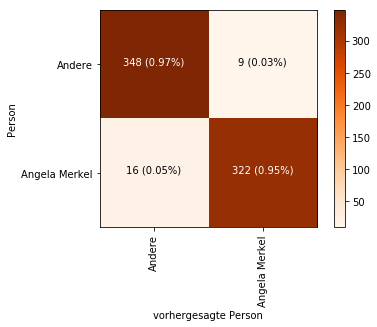

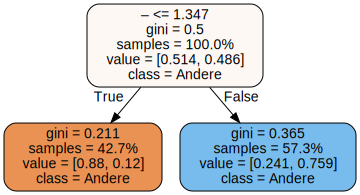

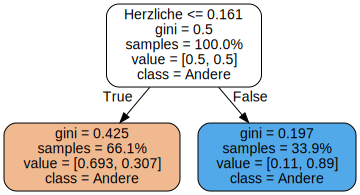

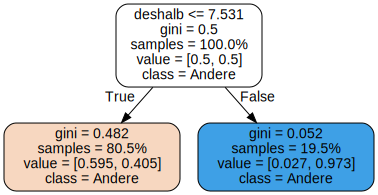

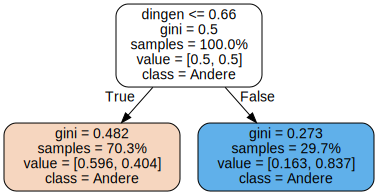

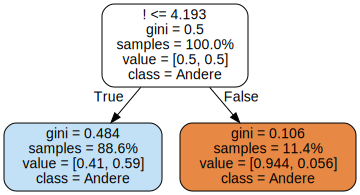

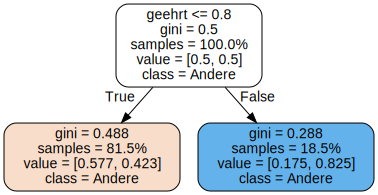

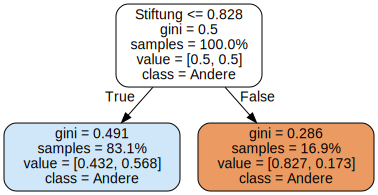

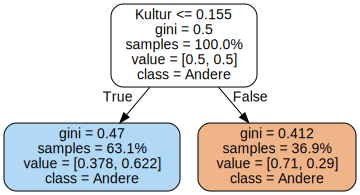

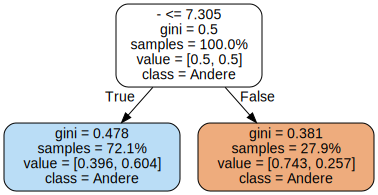

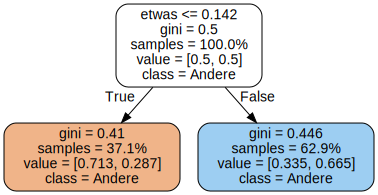

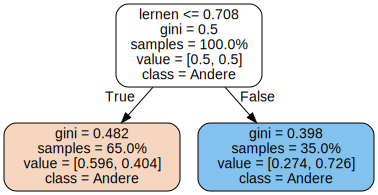

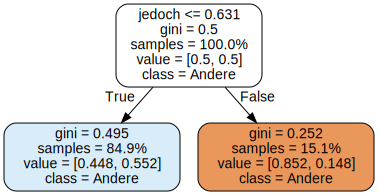

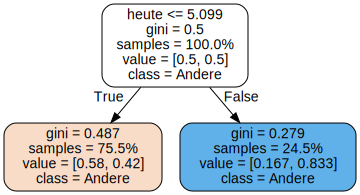

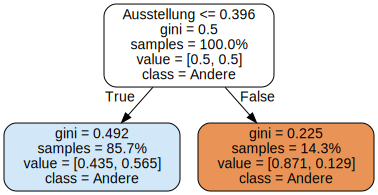

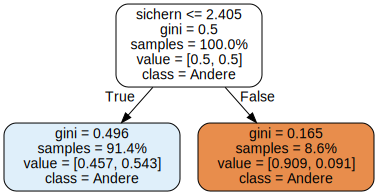

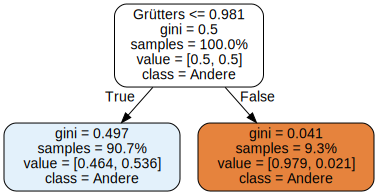

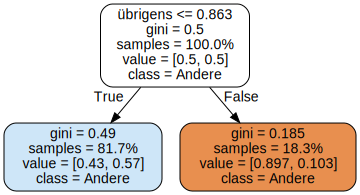

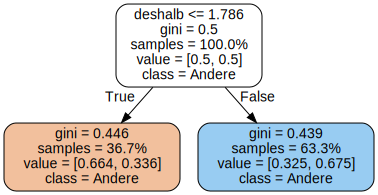

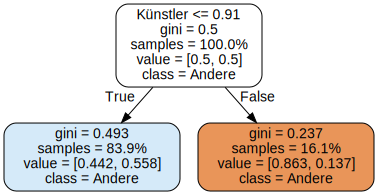

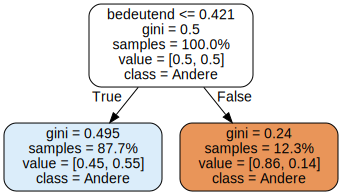

In [11]:
from sklearn.ensemble import AdaBoostClassifier

base = make_decision_tree_classifier()
classifier = AdaBoostClassifier(base_estimator=base,
                                n_estimators=BOOST_FACTOR)

(accuracy, confusion) = train_and_test_with(classifier,
                                            data,
                                            labels,
                                            test_size=TRAIN_TEST_RATIO)

display(accuracy)
plot_confusion_matrix(confusion, classes=categories.unique())
for tree in classifier:
    display_decision_tree(tree)

0.9194244604316547

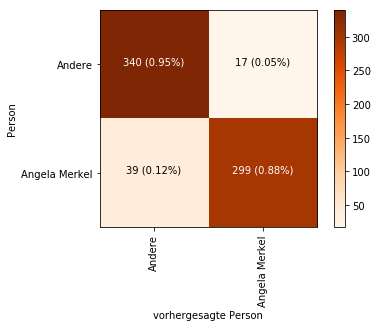

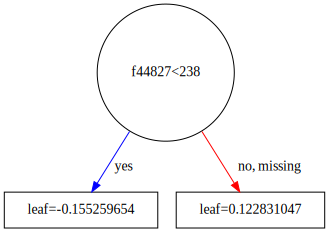

In [12]:
from xgboost import XGBClassifier
import xgboost

base = make_decision_tree_classifier()
classifier = XGBClassifier(max_depth=1,
                           n_estimators = BOOST_FACTOR)

(accuracy, confusion) = train_and_test_with(classifier,
                                            data,
                                            labels,
                                            test_size=TRAIN_TEST_RATIO)

display(accuracy)
plot_confusion_matrix(confusion, classes=categories.unique())
display(graphviz.Source(xgboost.to_graphviz(classifier)))